# Heartbeat Audio Classification

In [1]:
# Import dependencies
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import glob
import numpy as np
import pandas as pd

## The Data

The data is a set of heartbeat audio recordings labelled into three different categories (normal, murmur, or extrastole (i.e. extrasystole)). 

In [2]:
dataset = [{'path': path, 'label': path.split('/')[6]} 
               for path in glob.glob("/Users/marshal/Projects/heartbeat/dataset/**/*.wav")]
df = pd.DataFrame.from_dict(dataset)

# Add a column to store the data read from each wavfile...   
df['x'] = df['path'].apply(lambda x: wavfile.read(x)[1])
df.head()

,label,path,x
0,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[761, 359, 433, 360, 428, 560, 578, 829, 687, ..."
1,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[479, 452, 433, 420, 370, 391, 344, 392, 403, ..."
2,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-982, -973, -832, -813, -409, -231, -386, -23..."
3,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-195, -97, 280, 331, 141, 242, 204, 190, 94, ..."
4,murmur,/Users/marshal/Projects/heartbeat/dataset/murm...,"[-703, -1073, -1345, -1006, -1089, -1601, -160..."


## Visualizing the data

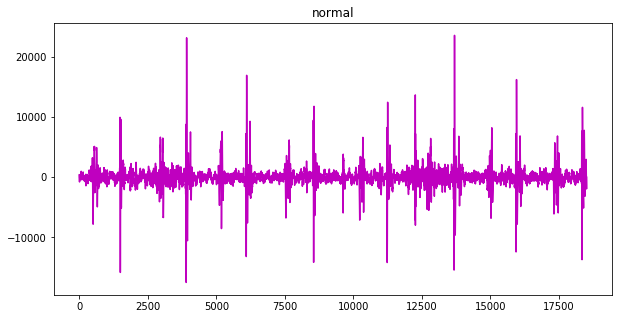

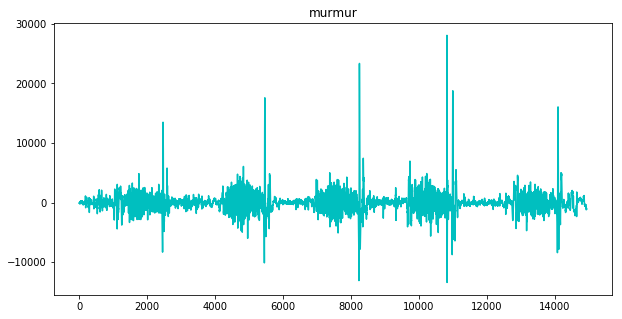

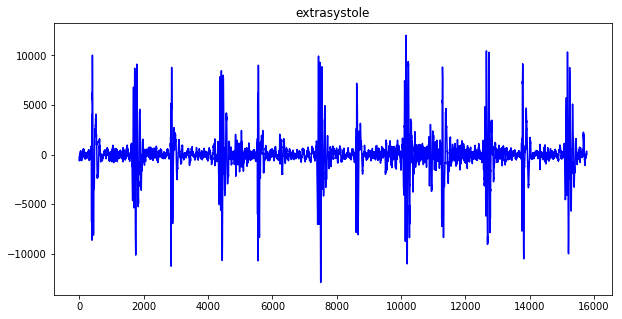

In [3]:
# Collect three samples from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
murmur = df[df['label'] == 'murmur' ].sample(1)
extrasystole = df[df['label'] == 'extrastole' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(10,5))
plt.title('normal')
plt.plot(normal['x'].values[0], c='m')

plt.figure(2, figsize=(10, 5))
plt.title('murmur')
plt.plot(murmur['x'].values[0], c='c')

plt.figure(3, figsize=(10, 5))
plt.title('extrasystole')
plt.plot(extrasystole['x'].values[0], c='b')

## Preprocessing the Data

The audio recordings are of varying lengths. This will become a problem when we need to train a model. So, to resolve this, I repeat the data read from the wavefile until the longest file's time has been reached.

In [4]:
max_length = max(df['x'].apply(len))

# Kaggle: What's in a heartbeat? - Peter Grenholm
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = np.float32)
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df['x'] = df['x'].apply(repeat_to_length, length=max_length)
df.head()

Now that the data is of consistent shape, let's see if we can spot the difference between the classes ourselves.

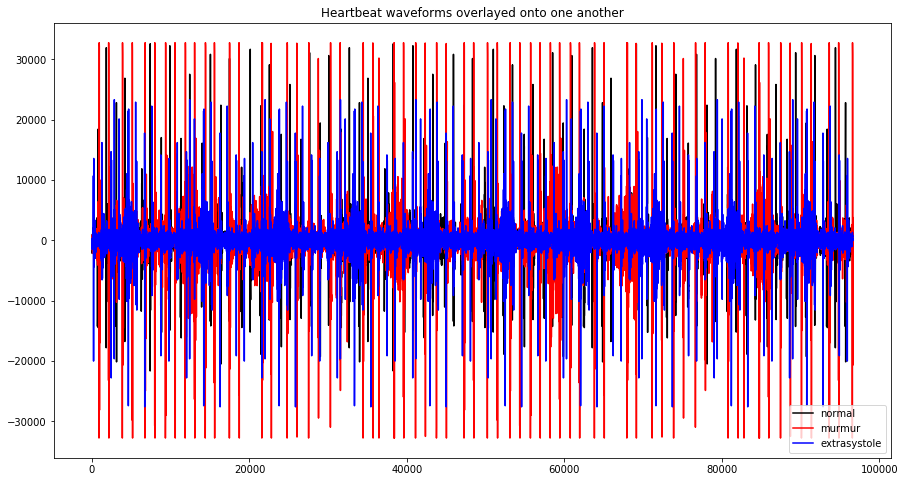

In [6]:
# Collect three samples from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
murmur = df[df['label'] == 'murmur' ].sample(1)
extrasystole = df[df['label'] == 'extrastole' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(15,8))
plt.plot(normal['x'].values[0], c='k', label='normal')

plt.figure(1)
plt.plot(murmur['x'].values[0], c='r', label='murmur')

plt.figure(1)
plt.plot(extrasystole['x'].values[0], c='b', label='extrasystole')

plt.title('Heartbeat waveforms overlayed onto one another')
plt.legend(loc='lower right')
# plt.savefig('temp.png')

#### The same visualization but as a spectrogram

Text(0.5,0,'Time [sec]')

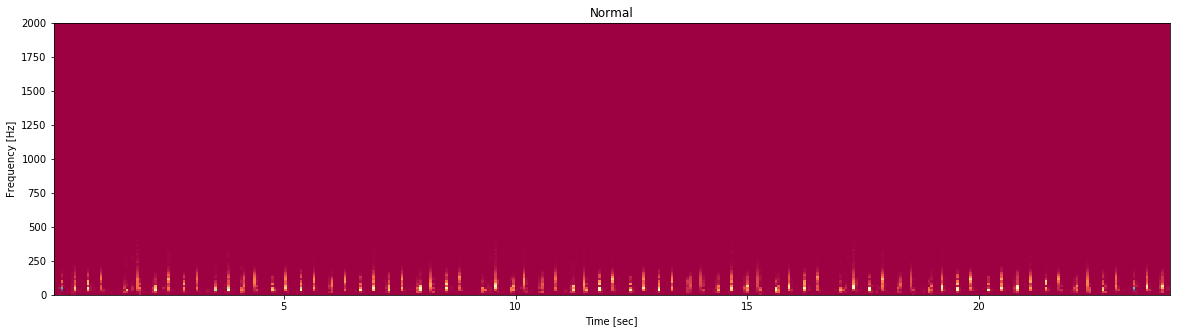

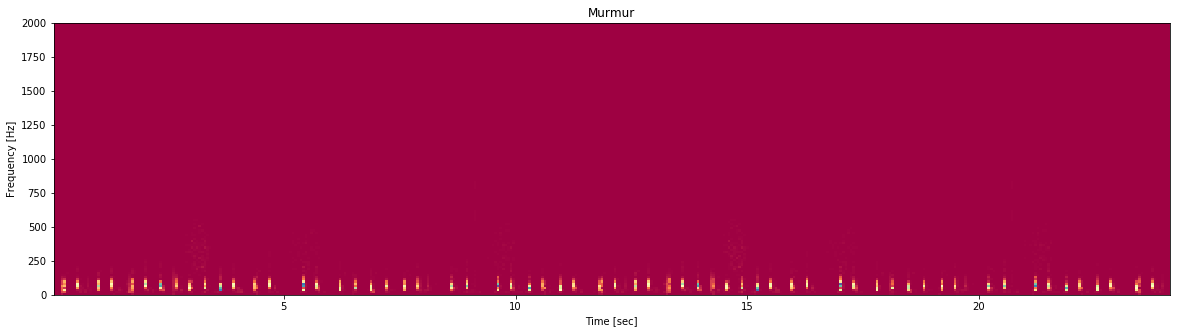

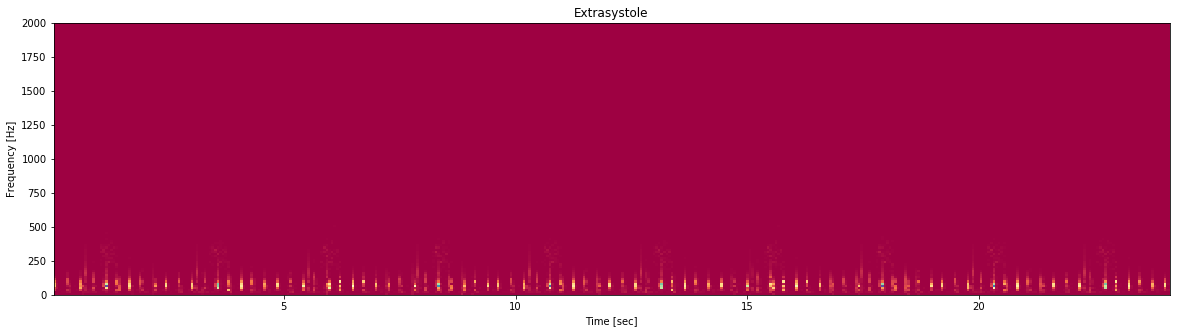

In [7]:
from scipy.signal import spectrogram

fs = 4000
f_normal, t_normal, Sxx_normal = spectrogram(normal['x'].values[0], 4000)
plt.figure(1, figsize=(20,5))
plt.title('Normal')
plt.pcolormesh(t_normal, f_normal, Sxx_normal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_murmur, t_murmur, Sxx_murmur = spectrogram(murmur['x'].values[0], 4000)
plt.figure(2, figsize=(20, 5))
plt.title('Murmur')
plt.pcolormesh(t_murmur, f_murmur, Sxx_murmur, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

f_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)
plt.figure(3, figsize=(20, 5))
plt.title('Extrasystole')
plt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

# plt.savefig('normal_spectrogram.png', dpi=1000)

In [8]:
# Put the data into numpy arrays. Most machine learning libraries use numpy arrays.
x = np.stack(df['x'].values, axis=0)

# Convert the string categories into integer labels
# y = pd.factorize(df['label'])[0]
# Convert the integer labels into one-hot-encoded vectors
# y = tf.keras.utils.to_categorical(y)

In [11]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x, df['label'].values, 
                                                                                     df['path'].values,
                                                                                     test_size=0.25)

## Create a model

I think a Convolutional Neural Network may work best here. But let's try some simpler models first.

### 1. A Multi-Layer Perceptron Model

In [12]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# We need quite a few hidden layers here since we are doing a fairly high level task.
clf = MLPClassifier(hidden_layer_sizes=(512,256,128,), 
                    max_iter=5000, verbose=True)
clf.fit(x_train, y_train)

Iteration 1, loss = 17.36340650
Iteration 2, loss = 4.36742646
Iteration 3, loss = 1.05913613
Iteration 4, loss = 0.26516618
Iteration 5, loss = 0.26519285
Iteration 6, loss = 0.00055476
Iteration 7, loss = 0.13291371
Iteration 8, loss = 0.13293926
Iteration 9, loss = 0.00063123
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(512, 256, 128), learning_rate='constant',
       learning_rate_init=0.001, max_iter=5000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [13]:
# Predict new, unseen data
predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy %.3f" % accuracy)

Accuracy 0.441


Surely we can do much better than that! Let's try a much more complex model architecture.

### 2. A Convolutional Neural Network (CNN) Model